# Kickstarter: Exploration & Prediction
By:
* Cen Liang
* Mahmoud Belhaj
* Jonas Cristens

### Load the required packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score
from sklearn.ensemble import ExtraTreesClassifier

from scikitplot.metrics import plot_confusion_matrix
from scikitplot.estimators import plot_feature_importances
from imblearn.over_sampling import SMOTE

### Read the Kickstarter projects file 201801 csv and parse the dates and change the categorical columns to categories

In [2]:
df = pd.read_csv('ks-projects-201801.csv', parse_dates = ['launched', 'deadline'], index_col = 'ID')
df = df.astype({"category": 'category',
                "main_category": 'category', 
                "currency": 'category', 
                'state' : 'category', 
                'country' : 'category',
               })
df.head()

,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
ID,,,,,,,,,,,,,,
1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,2015-10-09,1000.0,2015-08-11 12:12:28,0.0,failed,0,GB,0.0,0.0,1533.95
1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,2017-11-01,30000.0,2017-09-02 04:43:57,2421.0,failed,15,US,100.0,2421.0,30000.00
1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2013-02-26,45000.0,2013-01-12 00:20:50,220.0,failed,3,US,220.0,220.0,45000.00
1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,2012-04-16,5000.0,2012-03-17 03:24:11,1.0,failed,1,US,1.0,1.0,5000.00
1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,2015-08-29,19500.0,2015-07-04 08:35:03,1283.0,canceled,14,US,1283.0,1283.0,19500.00


### Check if there is data missing

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 378661 entries, 1000002330 to 999988282
Data columns (total 14 columns):
name                378657 non-null object
category            378661 non-null category
main_category       378661 non-null category
currency            378661 non-null category
deadline            378661 non-null datetime64[ns]
goal                378661 non-null float64
launched            378661 non-null datetime64[ns]
pledged             378661 non-null float64
state               378661 non-null category
backers             378661 non-null int64
country             378661 non-null category
usd pledged         374864 non-null float64
usd_pledged_real    378661 non-null float64
usd_goal_real       378661 non-null float64
dtypes: category(5), datetime64[ns](2), float64(5), int64(1), object(1)
memory usage: 31.1+ MB


There is no missing data, there in total 378661 rows and 16 columns.

In [4]:
df.describe()

,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


### Check the data types

In [5]:
df.dtypes

name                        object
category                  category
main_category             category
currency                  category
deadline            datetime64[ns]
goal                       float64
launched            datetime64[ns]
pledged                    float64
state                     category
backers                      int64
country                   category
usd pledged                float64
usd_pledged_real           float64
usd_goal_real              float64
dtype: object

The dtypes are correct now we can calculate the difference in days between `launced` and `deadline`.

In [6]:
df['days_to_collect'] = (df['deadline'] - df['launched']).dt.days
df['days_to_collect'].head(5)

ID
1000002330    58
1000003930    59
1000004038    44
1000007540    29
1000011046    55
Name: days_to_collect, dtype: int64

### Average amount per day needed to reach the goal

In [7]:
# replace the inf values with 0 (0/something) = np.inf) 
df['usd_needed_per_day'] = (df['usd_goal_real'] / df['days_to_collect']).replace([np.inf, -np.inf], 0)

### What are the different Kickstarter states?

In [8]:
df['state'].unique()

[failed, canceled, successful, live, undefined, suspended]
Categories (6, object): [failed, canceled, successful, live, undefined, suspended]

We define 
* `failed`, `canceled`, `undefined` and `suspended` as failed.
* `successful` as success.
* `live` not relevant ==> will be deleted since our goal is to predict if it will fail or succeed

In [9]:
conditions = [df['state'].isin(['failed', 'canceled', 'undefined', 'suspended']),
             df['state'].isin(['successful'])]
df['cln_state'] = np.select(conditions, [-1, 1])

### Calculate the average contribution per backer

In [10]:
# replace the inf values with 0 (0/something) = np.inf) 
df['usd_per_backer'] = (df['usd_goal_real'] / df['backers']).replace([np.inf, -np.inf], 0)

### Plot the distribution of the numerical variables

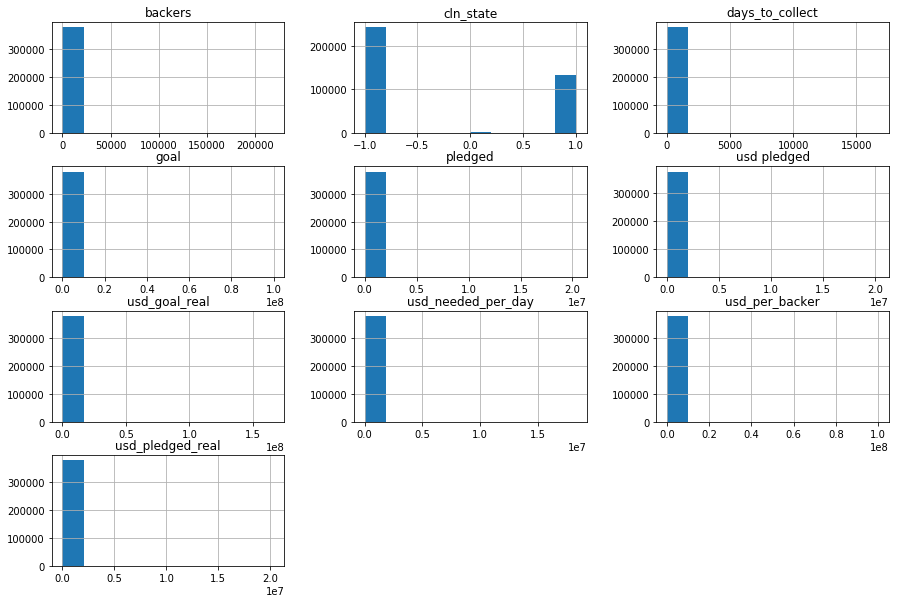

In [11]:
df.hist(figsize=(15,10));

The difference between the average and max value is huge. This means that there are serious outliers which we decided to delete (this will be done in the next step). The outliers will be removed by removing the data which is 3 or more standard deviations away from the mean.

In [12]:
cols = df.select_dtypes([np.number]).columns

In [13]:
df[cols] = df[cols].mask((df[cols] - df[cols].mean()).abs() > 3 * df[cols].std())
df = df.dropna()

In [14]:
# remove where cln_state = 0
df = df[df['cln_state'] !=0 ]

Now all the data which is more than 3 standard devations away from the mean is removed.

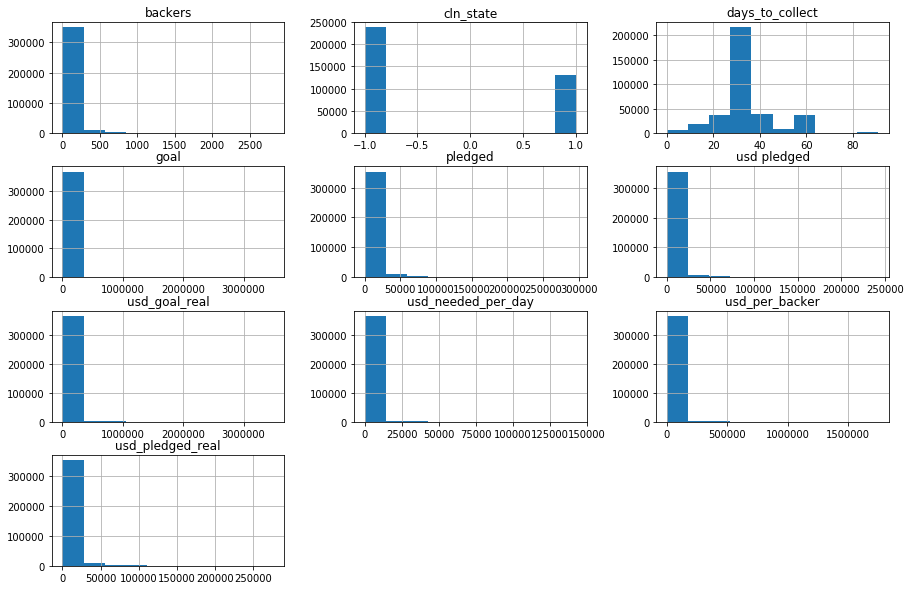

In [15]:
df.hist(figsize=(15,10));

In [16]:
df['cln_state'].unique()

array([-1,  1])

In [17]:
df = df.drop(columns=['name', 'deadline', 'launched', 'state'])

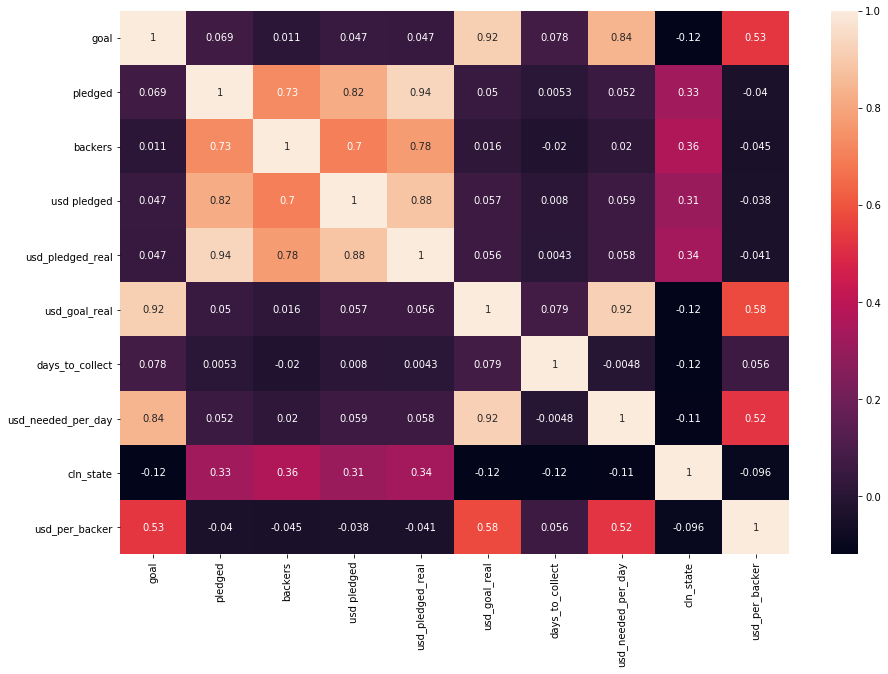

In [18]:
plt.subplots(figsize=(15,10))
sns.heatmap(df[cols].corr(), annot=True)

We choose the features `backers` and `usd_goal_real` to apply to logistic regression. We don't include the rest becasue the correlation between them is to high which can cause the algorithm to be confused and not find the optimal weights.

In [19]:
X = df[['backers', 'usd_goal_real']]
y = df['cln_state']

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [21]:
clf = LogisticRegression(penalty='l1')

In [22]:
clf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [23]:
y_pred = clf.predict(X_test)

In [24]:
accuracy_score(y_test, y_pred)

0.9195756246971973

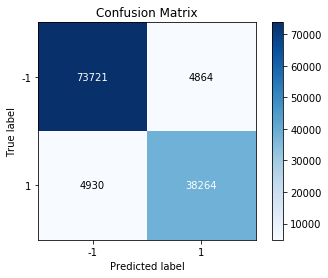

In [25]:
plot_confusion_matrix(y_test, y_pred)

### ExtraTreeClassifier

In [26]:
df = pd.get_dummies(df)

In [27]:
X = df.drop(columns ='cln_state')
y = df['cln_state']

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [29]:
clf = ExtraTreesClassifier()
clf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [30]:
y_pred = clf.predict(X_test)

In [31]:
accuracy_score(y_test, y_pred)

0.9793724698018542

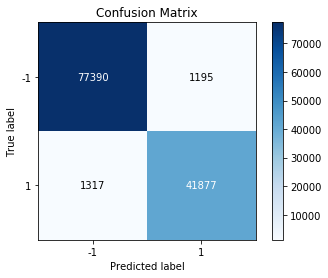

In [32]:
plot_confusion_matrix(y_test, y_pred)

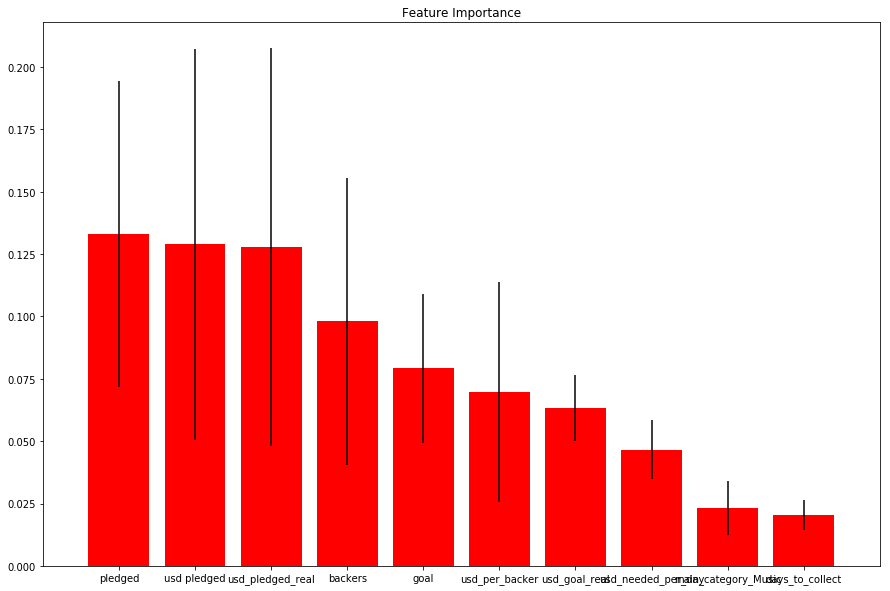

In [33]:
fig, ax = plt.subplots(figsize=(15,10))
plot_feature_importances(clf, feature_names=X.columns.values, max_num_features=10, ax=ax)